# Linear Scheduling Problem

## Battery Energy Scheduling for Revenue Maximization

We consider an energy storage device (battery) operating over a discrete time horizon (12 time steps).  
At each time step, the battery may receive incoming energy and may discharge energy to  
sell electricity to the market.  
  
  
The electricity price varies over time and is known in advance.  
The battery has physical limitations, including a maximum storage capacity and limits  
on how much energy can be discharged at each time step.  
  
  
The state of charge of the battery evolves over time based on the energy flowing into  
and out of the battery.
  
  
**Objective:**  
Determine how much energy to sell at each time step in order to maximize total revenue  
from electricity sales over the entire time horizon, while respecting all battery  
and operational constraints.  

### Problem Disection

**Sets:**  
The optimization problem is evaluated over a discrete time horizon consisting of 12 time steps.

$T$ – Set of all time steps, where $t \in T = \{1, 2, \dots, 12\}$
  
  
**Parameters:**  
The model includes both time-dependent parameters and scalar parameters.

$P_t$ – Electricity price at time $t \in T$  
$Q_t$ – Energy input(charging) at time $t \in T$  
$S^0$ – Initial state of charge of the storage system  
$W^{\max}$ – Maximum power that can be sold at any time step

**Decision Variables:**  

$w_t$ – Power sold at time $t \in T$  
$s_t$ – Energy stored in the battery at time $t \in T$

**Objective:**  
As for the objective we would mathematize it as follows  
$ Max: Z = \sum (P_t \times w_t) $  
where this means we want to maximize the amount of revenue by finding out how much power is sold with a certain price at a time.

**Constraints:**

1. **Power limit:** Ensure we do not sell more power than allowed:

$ w_t \leq W^{\max} \quad \forall t \in T $  

2. **Battery Capacity limit:** The battery cannot exceed its maximum capacity:  

$ s_t \leq S^0 \quad \forall t \in T $

3. **Energy balance / inventory tracking:** Keep track of energy in the storage over time:

$ s_t - s_{t-1} = Q_t - w_t \quad \forall t \in T, t \geq 2 $

4. **Initial storage balance:** For the first time step:

$ s_1 - S^0 = Q_1 - w_1 $

5. **Sell Limit:** Ensure we dont sell more power than what we have currently  (not in video)

$ w_t \leq s_t $

6. **Non-negativity:**

$ w_t \geq 0, \quad s_t \geq 0 \quad \forall t \in T $  



**The Meaning of Each Symbol**  
$x \in X$ - means `for x in X`  
$ \forall $ - means `for all`

### Code

#### Import Libraries

In [1]:
import pyomo.environ as pyomo
import matplotlib.pyplot as plt

#### The data

In [2]:
# P_t: Electricity price at each time step
P_t = {
    0 : 0.5,
    1 : 0.6,
    2 : 1.0,
    3 : 1.0,
    4 : 0.9,
    5 : 1.1,
    6 : 1.8,
    7 : 1.5,
    8 : 0.9,
    9 : 0.8,
    10 : 0.7,
    11 : 1.0
}

# Q_t: Energy inflow (charging) at each time step
Q_t = {
    0 : 0.,
    1 : 0.,
    2 : 0.,
    3 : 0.,
    4 : 0.3,
    5 : 0.15,
    6 : 0.15,
    7 : 0.05,
    8 : 0.05,
    9 : 0.05,
    10 : 0.,
    11 : 0.
}


NOTE:  
`P_t` and `Q_t` are dictionaries that map each time step (0 to 11) to a value.

`P_t[t]` gives the electricity price at time `t`.

`Q_t[t]` gives the energy coming into the storage at time `t`.

Pyomo uses these dictionaries to iterate over the time steps when defining constraints and the objective function.

The format ensures Pyomo can automatically link each variable and constraint to the correct time step.

##### Visualization of the Price and Energy Input

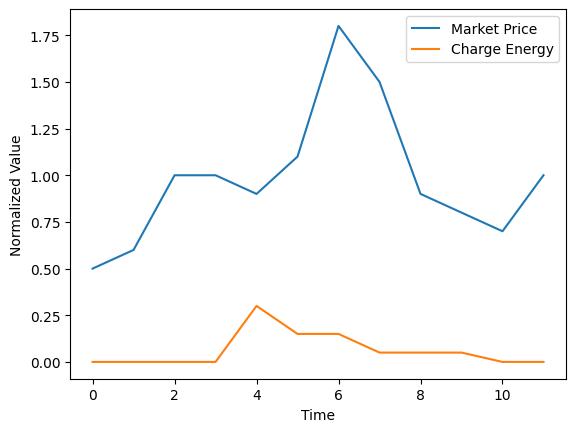

In [3]:
plt.plot(range(12), [P_t[i] for i in range(12)], label="Market Price")
plt.plot(range(12), [Q_t[i] for i in range(12)], label="Charge Energy")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()

#### Initialize Pyomo Model

In [4]:
model = pyomo.ConcreteModel()

#### Creating Variables

In [5]:
# Initialize a set of time steps
model.T = pyomo.Set(initialize=P_t.keys())

# Sales price at each time step
model.price = pyomo.Param(model.T, initialize=P_t)
# this means the values in model.price will correspond to the keys from P_t dictionary where model.T would act as the indexer to retrieve the values

# Energy inflow (charging) at each time step
model.charge = pyomo.Param(model.T, initialize=Q_t)
# this means the values in model.charge will correspond to the keys from Q_t dictionary

# Initial/Maximum charge capacity
model.S0 = pyomo.Param(initialize=500.)

# Maximum instanteous power
model.wmax = pyomo.Param(initialize=150.)

"""Decision Variables"""
# Power Output at t
model.w = pyomo.Var(model.T, domain=pyomo.NonNegativeReals)
# This time we pass model.T (the set) as one of the argumets so that pyomo can assign how much power output at eeach timestamp t

# Energy Stored at t
model.s = pyomo.Var(model.T, domain=pyomo.NonNegativeReals)
# This time we pass model.T (the set) as one of the argumets so that pyomo can assign how much energy would be stored at eeach timestamp t

In the [previous notebook](01_Linear_Programming.ipynb#Creating_Variables), we used `pyomo.Var` to create **decision variables**.
Decision variables are values that the **solver is allowed to choose**.

This time, we use **`pyomo.Param`**, which is similar in syntax to `pyomo.Var`, but has a **different role**:

* `pyomo.Param` represents **fixed data / constants**
* Parameters **must be initialized** using `initialize=`
* The solver **cannot change** parameter values

In other words:

* `Var` -> *solver decides the value*
* `Param` -> *we provide the value*

##### Sets in Pyomo

We also introduce **`pyomo.Set`**.

A `Set` is used to define **indexing structures**, such as time steps, products, locations, etc.

You can think of a `Set` as:

> a structured list of indices that Pyomo uses to iterate over variables, parameters, and constraints.  
> (i.e. an empty array that pyomo can use/experiment with)

Example:

```python
model.T = pyomo.Set(initialize=range(12))
```

This allows us to write compact models like:

```python
model.w = pyomo.Var(model.T)
model.price = pyomo.Param(model.T)
```

instead of manually defining variables and parameters one by one.

##### Quick Note

* `pyomo.Var` -> decision variables (chosen by the solver)
* `pyomo.Param` -> fixed input data (given by the user)
* `pyomo.Set` -> index sets that structure the model

#### Objective Function

In [6]:
# this time we would pass a function as the objective
def obj_func(model): # in Pyomo, the model is always passed in
    # sum of all the revenue at t
    return sum([model.w[t] * model.price[t] for t in model.T])

model.objective = pyomo.Objective(rule = obj_func, 
                                  sense = pyomo.maximize
                                  )

#### Constraints

In [7]:
# we will make functions for each constraints due to the constraints is time based (more complicated lol)

# The maximum battery/storage capacity (where previously we assume the maximum battery/storage capacity is the initial capacity)
def constr_battery_capacity(model, t): # we have two arguments. the model and the timestep since we assume pyomo would return the time step too
    return model.s[t] <= model.S0
model.constr_battery_capacity = pyomo.Constraint(model.T, # The model is passed so that pyomo can iterate over the timestep and evaluate
                                                 rule = constr_battery_capacity)

# Power Output Constraint (limited by wmax)
def constr_power(model, t):
    return model.w[t] <= model.wmax
model.constr_power = pyomo.Constraint(model.T,
                                      rule = constr_power)

# energy balance on battery based on power consumed
def constr_battery_balance(model, t):
    if t == model.T.first():
        # initial storage at step 0
        return model.s[t] == model.S0 - model.w[t] + model.charge[t]*model.S0
    else:
        return model.s[t] == model.s[t-1] - model.w[t] + model.charge[t]*model.S0

model.constr_battery_balance = pyomo.Constraint(model.T,
                                               rule = constr_battery_balance)

# Another power output constraint where we cant sell more than we have (not in video)
def constr_energy_available(model, t):
    return model.w[t] <= model.s[t]

model.constr_energy_available = pyomo.Constraint(model.T,
                                                 rule=constr_energy_available
                                                 )


**Note on charging parameter \(Q_t\):**

$ Q_t $ represents the *fraction of the maximum battery capacity* charged at time $ t $.  

The actual energy added to storage at each time step is therefore:

$ Charge_t = Q_t \times S^0 $


#### Creating Solver

In [8]:
solver = pyomo.SolverFactory("glpk")
result = solver.solve(model)

#### Results

In [9]:
print(result)


Problem: 
- Name: unknown
  Lower bound: 1042.5
  Upper bound: 1042.5
  Number of objectives: 1
  Number of constraints: 48
  Number of variables: 24
  Number of nonzeros: 83
  Sense: maximize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.0021533966064453125
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



##### Display Model
this includes constraints and variables

In [10]:
print(model.display())

Model unknown

  Variables:
    w : Size=12, Index=T
        Key : Lower : Value   : Upper : Fixed : Stale : Domain
          0 :     0 :     0.0 :  None : False : False : NonNegativeReals
          1 :     0 :     0.0 :  None : False : False : NonNegativeReals
          2 :     0 :   150.0 :  None : False : False : NonNegativeReals
          3 :     0 :    75.0 :  None : False : False : NonNegativeReals
          4 :     0 :     0.0 :  None : False : False : NonNegativeReals
          5 :     0 :   150.0 :  None : False : False : NonNegativeReals
          6 :     0 :   150.0 :  None : False : False : NonNegativeReals
          7 :     0 :   150.0 :  None : False : False : NonNegativeReals
          8 :     0 :    87.5 :  None : False : False : NonNegativeReals
          9 :     0 :   56.25 :  None : False : False : NonNegativeReals
         10 :     0 :  28.125 :  None : False : False : NonNegativeReals
         11 :     0 : 14.0625 :  None : False : False : NonNegativeReals
    s : 

##### Optimization Results

General Rule in Extracting the Values of the Optimization
| Component     | How to access value   |
| ------------- | --------------------- |
| `pyomo.Var`   | `model.x[t]()`      |
| `pyomo.Param` | `model.p[t]`        |
| `pyomo.Param` | `value(model.p[t])` |

In [11]:
print(f"time \t price \t power \t charge_available")
for t in model.T:
    print(f"{t} \t {model.price[t]:.2f} \t {model.w[t]():>5.1f} \t {model.s[t]():5.1f}")

time 	 price 	 power 	 charge_available
0 	 0.50 	   0.0 	 500.0
1 	 0.60 	   0.0 	 500.0
2 	 1.00 	 150.0 	 350.0
3 	 1.00 	  75.0 	 275.0
4 	 0.90 	   0.0 	 425.0
5 	 1.10 	 150.0 	 350.0
6 	 1.80 	 150.0 	 275.0
7 	 1.50 	 150.0 	 150.0
8 	 0.90 	  87.5 	  87.5
9 	 0.80 	  56.2 	  56.2
10 	 0.70 	  28.1 	  28.1
11 	 1.00 	  14.1 	  14.1


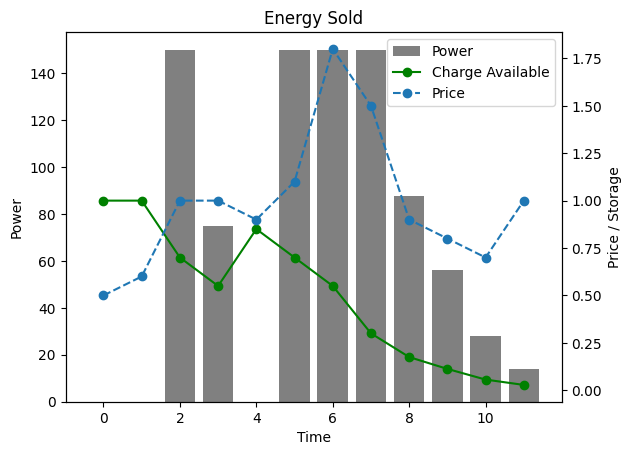

In [12]:
fig, ax1 = plt.subplots()

# Power (left axis)
ax1.bar(range(len(P_t)), [model.w[t]() for t in model.T], color="gray", label="Power")
ax1.set_ylabel("Power")
ax1.set_xlabel("Time")

# Second axis
ax2 = ax1.twinx()
ax2.plot(
    range(len(P_t)),
    [model.s[t]() / model.S0 for t in model.T],
    color="green",
    label="Charge Available",
    marker="o"
)
ax2.plot(
    range(len(P_t)),
    [model.price[t] for t in model.T],
    label="Price",
    linestyle="--",
    marker="o"
)
ax2.set_ylabel("Price / Storage")

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2)

plt.title("Energy Sold")
plt.show()
